# ASR-QA
## Lucida AI Evaluation

### Steps

1. Preprocess raw data
from `txt` files to panda `DataFrame`
2. Analyze
from panda `DataFrame` to statistics
3. Plot
from statistics to plot

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import re, string
from operator import itemgetter
import matplotlib.pyplot as plt

# Returns a DataFrame from the file with the following format:
# <audio_path>,<transcript>
# in which the audio path is of the following format:
# "path/to/file/<query_id>_<text>.wav"
# An example file:
# ../asr_qa/speech/0_Helloworld.wav,"hello world."
# The DataFrame has only one column: transcript
# with the specified header
# and sorted by the query id.
def get_df_from_asr_result(file_path, header):
    file = open(file_path, 'r')
    lines = file.readlines()
    file.close()
    proc_lines = []
    for line in lines:
        line = line.lstrip().rstrip('\n')
        # The first occurrence of a number is assumed to be the query id.
        id = int(re.search(r'\d+', line).group())
        transcript = line.split(',')[1]
        if transcript.startswith('"') and transcript.endswith('"'):
            transcript = transcript[1:-1]
        proc_lines.append((id, transcript))
    proc_lines.sort(key=itemgetter(0)) # sort data by ID
    df = pd.DataFrame([row[1] for row in proc_lines], columns=[header])
    return df

data = pd.read_csv('text/query.txt')
data = data.join(get_df_from_asr_result('asr_result_fisher.txt', 'fisher_transcript'))
data = data.join(get_df_from_asr_result('asr_result_librispeech.txt', 'librispeech_transcript'))
data = data.join(get_df_from_asr_result('asr_result_tedlium.txt', 'tedlium_transcript'))

In [2]:
# Add double quotes to each filed of a csv file 
# whcih has two fields.
# Print the processed lines out.
def add_double_quotes(file_path):
    file = open(file_path, 'r')
    lines = file.readlines()
    file.close()
    def process_str(str):
        return '"' + str + '"' if str and str[0] != '"' else str
    for line in lines:
        line = line.lstrip().rstrip('\n')
        first = line.split(',')[0]
        second = line.split(',')[1:]
        second = ''.join(x for x in second)
        print(process_str(first) + ',' + process_str(second))
# Normalize the following files.
# add_double_quotes('qa_result_fisher.txt')
# add_double_quotes('qa_result_librispeech.txt')
# add_double_quotes('qa_result_tedlium.txt')
# add_double_quotes('qa_result_regular.txt')
# add_double_quotes('text/query.txt')

In [3]:
# Returns a DataFrame from the file with the following format:
# <query>,<answer>
# An example file:
# "who is the president of usa.","Factoid not found in knowledge base."
# The DataFrame has only one column: answer
# with the specified header
# and sorted by the row index row `row_index` which satisfies
# data[match_col][row_index] == query.
def get_df_from_qa_result(file_path, header, data, match_col):
    file = open(file_path, 'r')
    lines = file.readlines()
    file.close()
    proc_lines = []
    for line in lines:
        line = line.lstrip().rstrip('\n')
        query = line.split(',')[0]
        match_row = -1
        # To compare a string with another with less strict conditions,
        # remove pucntuations from the string.
        def stripped_str(str):
            return str.translate(str.maketrans('', '', string.punctuation))
        for j, match_transcript in enumerate(data[match_col]):
            if stripped_str(match_transcript) == stripped_str(query):
                if match_row != -1:
                    raise RuntimeError('Find the query ' + query +' again!')
                match_row = j
        if match_row == -1:
            raise RuntimeError('Cannot find the query ' + query)
        # Have found exactly one line that matches the transcript.
        answer = line.split(',')[1:]
        answer = ''.join(x for x in answer)
        answer = answer.replace('Factoid not found in knowledge base.', '')
        answer = answer.replace(' (from Wikipedia: ', '')
        answer = answer.replace(')', '')
        if answer.startswith('"') and answer.endswith('"'):
            answer = answer[1:-1]
        if answer == '':
            answer = 'null'
        proc_lines.append((match_row, answer))
    assert(len(proc_lines) == len(lines))
    proc_lines.sort(key=itemgetter(0)) # sort data by row index
    df = pd.DataFrame([row[1] for row in proc_lines], columns=[header])
    return df

data = data.join(get_df_from_qa_result('qa_result_fisher.txt', 'fisher_answer', data, 'fisher_transcript'))
data = data.join(get_df_from_qa_result('qa_result_librispeech.txt', 'librispeech_answer', data, 'librispeech_transcript'))
data = data.join(get_df_from_qa_result('qa_result_tedlium.txt', 'tedlium_answer', data, 'tedlium_transcript'))
data = data.join(get_df_from_qa_result('qa_result_regular.txt', 'regular_answer', data, 'query'))

### Processed Data as Table
Let's print it out!

In [11]:
from IPython.display import display
data = data[['query', 'answer', 'regular_answer', 'fisher_transcript', 'fisher_answer', \
             'librispeech_transcript', 'librispeech_answer', 'tedlium_transcript', 'tedlium_answer']]
display(data[0:5])
data.to_csv('data.txt')

,query,answer,regular_answer,fisher_transcript,fisher_answer,librispeech_transcript,librispeech_answer,tedlium_transcript,tedlium_answer
0,Who is the current president of the United Sta...,Barack Obama,Barack Obama,so is the current president of the united stat...,null,WHO IS THE CURRENT PRESIDENT OF THE UNITED STA...,Barack Obama,who is the current president of the united sta...,Barack Obama
1,Who wrote the Walden?,Henry David Thoreau,Alan,right the long run.,null,WHO WROTE THE WALDEN.,null,here at the wall then.,null
2,Who founded Apple Inc.?,Steve Jobs Ronald Wayne and Steve Wozniak,Steve Jobs,sounded that's willing to.,null,WHO FOUNDED AT FULL LENGTH.,35 mm,who founded at the link.,null
3,Who is the first man on the moon?,Neil Armstrong,adam,so is the first man on the moon.,null,WHO IS THE FIRST MAN ON THE MOON.,adam,he was the first man on the moon.,null
4,Who founded the Black Panthers organization?,Huey P. Newton and Bobby Seale,Heron,sounded the black panthers organisation.,null,WHO FOUNDED THE BLACK FENCERS ORGANIZATION.,null,who founded the black panthers organization.,Heron


In [12]:
# Returns the error rate of str2 given str1 as the correct text.
def error_rate(str1, str2):
    split1 = str1.lower().split()
    split2 = str2.lower().split()
    correct_count = 0
    wront_count = 0
    for word in split1:
        if word in split2:
            correct_count += 1
        else:
            wront_count += 1
    return wront_count / (correct_count + wront_count)

# Returns true if the answer is the same as the correct answer.
# Returns false otherwise.
def answer_is_correct(answer, correct_answer):
    return answer.lower() in correct_answer.lower()

# Analyzes the data for the specified ASR and returns the statistics.
def analyze(data, asr_name):
    size = data.shape[0]
    asr_errors = np.zeros(size)
    for j, transcript in enumerate(data[asr_name + '_transcript']):
        asr_errors[j] = error_rate(data['query'][j], transcript)
    scores = np.zeros(size)
    relative_scores = np.zeros(size)
    regular_result = np.zeros(size)
    result = np.zeros(size)
    for j, answer in enumerate(data[asr_name + '_answer']):
        correct_answer = data['answer'][j]
        regular_answer = data['regular_answer'][j]
        if answer_is_correct(regular_answer, correct_answer):
            # Regualr is correct.
            regular_result[j] = 1
            if not answer_is_correct(answer, correct_answer):
                # Become wrong.
                scores[j] = 0
                relative_scores[j] = -2
#                 print('@@@ -2', j, asr_errors[j])
            else:
                # Still correct.
                print('@@@ 1', correct_answer, ';', answer)
                scores[j] = 1
                relative_scores[j] = 1
                result[j] = 1
        else:
            # Regular is wrong.
            if not answer_is_correct(answer, correct_answer):
                # Still wrong.
                scores[j] = 0
                relative_scores[j] = -1
            else:
                # Become correct!
                print('@@@ 2', correct_answer, ';', answer)
                scores[j] = 1
                relative_scores[j] = 2
                result[j] = 1
    
    accuracy = np.count_nonzero(result) / result.size
    print('avg_asr_error:', asr_errors.mean(), 'accuracy:', accuracy)
    return {'asr_name': asr_name, 'asr_errors': asr_errors, \
            'avg_asr_error': asr_errors.mean(), \
            'relative_scores': relative_scores, \
            'regular_result': regular_result, 'result': result, \
            'accuracy': accuracy}

# Plot.
def plot(color, asr_name, asr_errors, relative_scores, **extras):
    fig = plt.figure()
    plt.rc("font", family="serif")
    plt.rc("font", size=15)
    plt.xlabel('Error Rate')
    plt.ylabel('Score')
    plt.title(asr_name)
    plt.scatter(asr_errors, relative_scores, label=asr_name, color=color)


### Plots
Explanation: `scores` are relative to the baseline (i.e. no ASR):
1. If the baseline is correct but the ASR causes it to be wrong, the score is -2
2. If the baseline is correct and the ASR does not change the result, the score is +1
3. If the baseline is wrong and the ASR does not change the result, the score is -1
2. If the baseline is wrong but the ASR causes it to be correct, the score is +2

@@@ 1 Egypt ; Egypt
@@@ 1 Valladolid Spain ; Spain
avg_asr_error: 0.537023282273 accuracy: 0.02


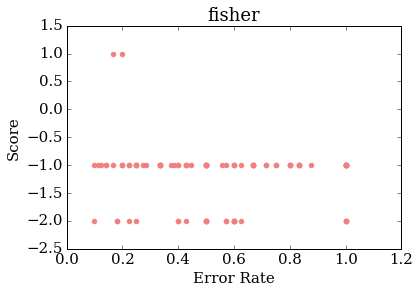

In [6]:
stats_list = []
stats_list.append(analyze(data, 'fisher'))
plot('lightcoral', **stats_list[-1])

@@@ 1 Barack Obama ; Barack Obama
@@@ 1 Alexander Graham Bell and Antonio Meucci ; Alexander Graham Bell
@@@ 1 Roald Amundsen ; Amundsen
@@@ 1 Geoffrey Chaucer ; Chaucer
@@@ 1 Henry Puyi ; Puyi
avg_asr_error: 0.372757659008 accuracy: 0.05


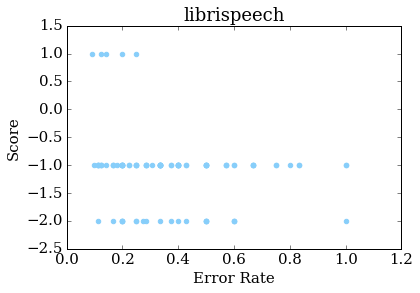

In [7]:
stats_list.append(analyze(data, 'librispeech'))
plot('lightskyblue', **stats_list[-1])

@@@ 1 Barack Obama ; Barack Obama
@@@ 1 Bill Gates ; Gates
@@@ 1 Valladolid Spain ; Spain
@@@ 1 Mona Lisa ; Mona Lisa
avg_asr_error: 0.424246725497 accuracy: 0.04


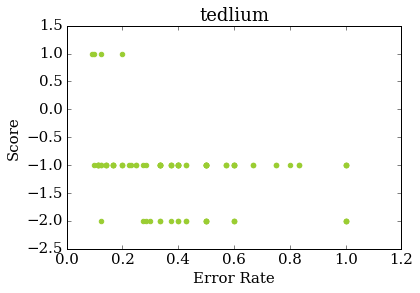

In [8]:
stats_list.append(analyze(data, 'tedlium'))
plot('yellowgreen', **stats_list[-1])

In [9]:
def plot(stats_list):    
    fig = plt.figure()
    plt.rc("font", family="serif")
    plt.rc("font", size=15)
    plt.xlabel('Average Error Rate')
    plt.ylabel('Accuracy')
    plt.title('No Inversion of Errors')

    avg_asr_error_list = [stat['avg_asr_error'] for stat in stats_list]
    accuracy_list = [stat['accuracy'] for stat in stats_list]
    plt.scatter(avg_asr_error_list, accuracy_list, color='orange')
    for i, txt in enumerate(avg_asr_error_list):
        plt.annotate \
        ('({},{})'.format(avg_asr_error_list[i], accuracy_list[i]), \
         (avg_asr_error_list[i], accuracy_list[i]))


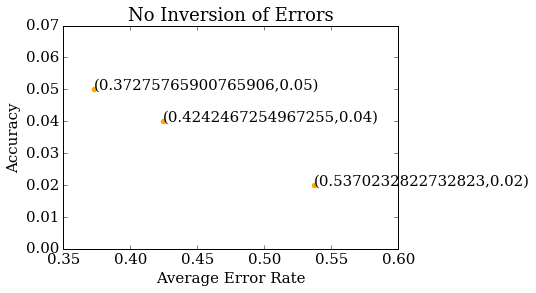

In [10]:
plot(stats_list)